In [1]:
#=====[ Import dependencies ]====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle

sys.path.append('data')
sys.path.append('squat_pushupData_10to20')

#=====[ Import Data ]=====
import coords1 as cd
import coordKeys as keys
import coordKeysZ as keysZ

%matplotlib inline

#Step 1: Import Data

In [2]:
#=====[ Option 1: Import data from text file ] =====

front_cut = 30
back_cut = 30
data = []
with open('data/squat_pushupData_10to20/squatData12.txt') as f:
    for line in f:
        data.append([float(x.replace('\r\n','')) for x in line.split(',')])

df = pd.DataFrame(data, columns=keysZ.columns)
df = df[front_cut:df.shape[0]-back_cut]
df = df.set_index([range(0,df.shape[0])])
#=====[ Option 2: Get data from python file and place in DataFrame ]=====
# data = cd.data
# df = pd.DataFrame(data,columns=keys.columns)

#Step 2: Isolate Individual Squats

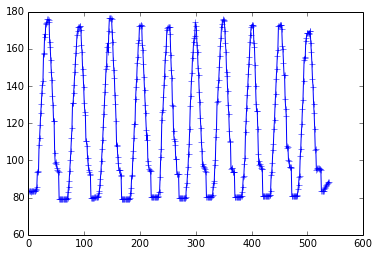

In [3]:
#=====[ Extract y_coords for Neck -- provides a stable point of reference ]=====
y_coords = np.array(df.get('NeckY'))
plt.plot(y_coords,marker='+')

#Get Max Indices

In [4]:
def is_min(y_coords, height, gradient, index, epsilon, beta):
    if np.abs(y_coords[index] - height)/height < epsilon:
        for i in range(1,beta):
            if gradient[index - i] > 0 or gradient[index + i - 1] < 0:
                return False
        return True
        
def in_new_squat(y_coords, height, index, delta):
    return abs((y_coords[index] - height)/height) > delta

#=====[ Gets local maxes within accepted epsilon of global max and with max len(y_coors)/gamma maxes ]=====
#=====[ For squats: usual epsilon ~ 0.05, gamma ~ 20, delta ~ 0.5, beta ~ 1 ]=====
def get_local_mins(y_coords, epsilon=0.15, gamma=20, delta=0.5, beta=1):
    
    local_mins = []
    height = np.min(y_coords)
    gradient = np.gradient(y_coords)
    
    #=====[ Checks gradients to make sure  ]=====
    min_located = False
    for index, dy in enumerate(gradient[2:]):
        if(min_located):
            if in_new_squat(y_coords, height, index, delta):
                min_located = False       
            else:
                continue
                
        if  is_min(y_coords, height, gradient, index, epsilon, beta + 1):
            local_mins.append(index)
            min_located = True
        
    return sorted(local_mins)

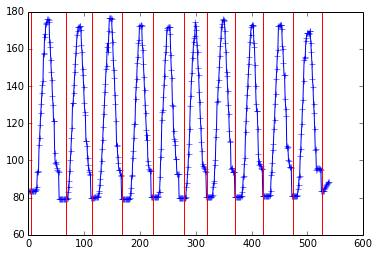

In [5]:
#=====[ Get maxes and plot with y_coords ]=====
mins = get_local_mins(y_coords)
plt.plot(y_coords,marker='+')

for divide in mins:
    plt.axvline(divide,color='r')

#Separate Exercise based on max points found

In [6]:
squats = []

#=====[ Get points from DF between each max found -- constitutes a single squat ]=====
for index,x in enumerate(mins):
    if(index == len(mins) -1 ):
        continue
    squat = (df.loc[x:mins[index+1]-1]).copy(True)
    squats.append(squat.set_index([range(squat.shape[0])]))

#Step 3: Normalize Coordinates

In [7]:
#=====[ Helper Functions for getting normalizing parameters ]=====
def y_upper_bound(df):
    return np.min(df['HeadY'])

def y_lower_bound(df):
    return np.median(pd.concat([df['FootRightY'],df['FootLeftY']],axis =0))

def x_zero(df):
    return np.median(df['SpineMidX'])

def z_zero(df):
    return np.median(np.concatenate([df.get('FootLeftZ'),df.get('FootRightZ')],axis=0))

def scaling_factor(df):
    return np.abs(y_upper_bound(df) - y_lower_bound(df))

In [8]:
def normalize(squats, z_coords=False):
    
    #=====[ Normalizing constants for the entire set of exercises ]=====
    y_head = y_upper_bound(df)
    scale = scaling_factor(df)
    x_midpoint = x_zero(df)
    if(z_coords):
        z_midpoint = z_zero(df)
    
    for squat in squats:
        
        #=====[ Even columns are x-coordinates, odd columns are y-coordinates -- normalize respectively ]=====
        if(not z_coords):
            for index, col in enumerate(squat.columns):
                if (index % 2) == 1:
                    squat[col] = squat[col].apply((lambda y: ((y - y_head)/scale)))
                else:
                    squat[col] = squat[col].apply((lambda x: ((x - x_midpoint)/scale)))
        else:
            for index, col in enumerate(squat.columns):
                if index % 3 == 2:
                    squat[col] = squat[col].apply((lambda z: ((z - z_midpoint)/scale)))
                elif index % 3 == 1:
                    squat[col] = squat[col].apply((lambda y: ((y - y_head)/scale)))
                else:
                    squat[col] = squat[col].apply(lambda x: ((x - x_midpoint)/scale))                    

In [9]:
#=====[ Normalize squats: ensure z_coords is set to true if extracting 3-d coordinates ]=====
normalize(squats,z_coords = True)

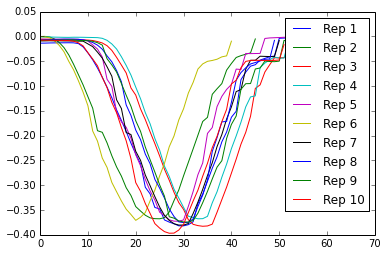

In [10]:
#=====[ Visual comparison between reps ]=====
for index, squat in enumerate(squats):
    plt.plot(-squat.get('HeadY'),label="Rep " + str(index + 1))
plt.legend()

In [11]:
training_data = []
label = 1

#=====[ Append label to our squats and pickle the (x,y) pairs ]=====
for squat in squats:
    training_data.append((squat,label))

In [12]:
#=====[ Save squats in pickle file if desired ]=====
pickle.dump(training_data,open('squats10.p','wb'))

#Visualize Scaled Body

In [13]:
def plotBody(df,frame,z_coords=False):
    coords = np.array(df.loc[frame])
    if not z_coords:
        xs = [coords[i] for i in range(0,coords.size) if i % 2 == 0]
        ys = [-1*coords[i] for i in range(0,coords.size) if i % 2 == 1]
    else:
        xs = [coords[i] for i in range(0,coords.size) if i % 3 == 0]
        ys = [-1*coords[i] for i in range(0,coords.size) if i % 3 == 1]    
    plt.plot(xs,ys,linestyle='None',marker='o')

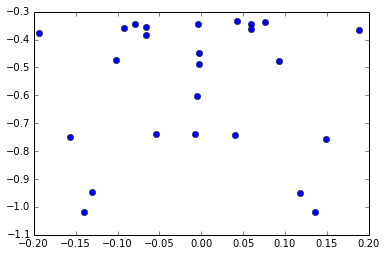

In [14]:
plotBody(squats[1],20,True)